# Clustering

## Based on the article [PATS](http://ismir2002.ircam.fr/proceedings/OKPROC02-FP07-4.pdf)

The ideia is to establish a similarity metric and do a clusterization process with these metrics. 

In [22]:
# Importing libraries 
import pandas as pd 
import numpy as np 

from sklearn.cluster import AffinityPropagation, SpectralClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

from seaborn import heatmap 
import matplotlib.pyplot as plt

I generated data for 50 users. We got 469 playlists. First I read these data an a Dataframe structure. I also drop duplicate track ids, because I 'll analyse it first. 

In [5]:
tracks = pd.read_pickle('../data/sp_tracks_ready_469.pkl')
playlists = pd.read_pickle('../data/sp_playlists.pkl')
audio_features = pd.read_pickle('../data/sp_audio_features.pkl')

tracks.drop_duplicates('id', inplace = True)
tracks = tracks.merge(audio_features, on = 'id')

I convert the dates to datetime and use the year as a timer. 

In [6]:
tracks['album_release_date'] = tracks['album_release_date'].apply(pd.to_datetime)
tracks['years'] = tracks['album_release_date'].apply(lambda x: x.year + x.month/12 + x.day/365)
tracks.set_index('id', inplace = True)
tracks.sample()

,added_at,added_by,is_local,playlist_id,available_markets,disc_number,duration_ms_x,explicit,name,popularity,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms_y,time_signature,years
id,,,,,,,,,,,,,,,,,,,,,
6bGhIJ1VeykhXlb11iU4tx,2017-08-03 01:27:29+00:00,taylordoboleto,False,0q2PbdjbI634whKRpaqnmH,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,267706.0,False,One More Chance,37.0,...,0,0.0315,0.764,0.0,0.106,0.224,179.231,267707,4,1995.963242


I separate the catefortical, numerical and set_oriented features. 

In [52]:
features_categorical =  ['explicit', 'album_type', 'album_id', 'key', 'mode', 'time_signature']
features_numerical = ['duration_ms_x', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'years']
features_set_oriented = ['artists_ids']

features = [] 
features.extend(features_categorical)
features.extend(features_numerical)
features.extend(features_set_oriented)

In [7]:
tracks[features_numerical] = tracks[features_numerical].astype(float)

Let's build the metrics proposed. For now, I normalize the numerical data, ensuring the range to be $[0,1]$. 

In [8]:
scaler = MinMaxScaler()
tracks[features_numerical] = scaler.fit_transform(tracks[features_numerical])

In [179]:
metric_categorical = lambda x1,x2: 1*(x1 == x2)
metric_set_oriented = lambda x1, x2: len(set(x1) & set(x2))/(max(len(x1), len(x2)))
metric_numerical = lambda x1, x2: 1 - abs(x1 - x2)

def metric_songs(x: np.array, y: np.array) -> float: 
    # Arbitrary choice 
    weight = [1/6 - 13/300]*6 + [1/50]*13
    
    similarity = 0
    for i in range(6):
        similarity += weight[i]*metric_categorical(x[i], y[i])
    for i in range(6,18):
        similarity += weight[i]*metric_numerical(x[i], y[i])
    similarity += weight[18]*metric_set_oriented(x[18], y[18])

    return similarity

## Simple example :


A matriz de similaridade agora é de distâncias depois da transformação. 

In [188]:
x1 = np.array(tracks[features].iloc[9])
x2 = np.array(tracks[features].iloc[99])
metric_songs(x1, x2)

0.4328896740178835

In [181]:
tracks_array = tracks[features].values

In [193]:
tracks_similarity = pdist(tracks_array[0:2000], metric = metric_songs)
tracks_similarity = - np.log(tracks_similarity)
tracks_similarity = squareform(tracks_similarity)

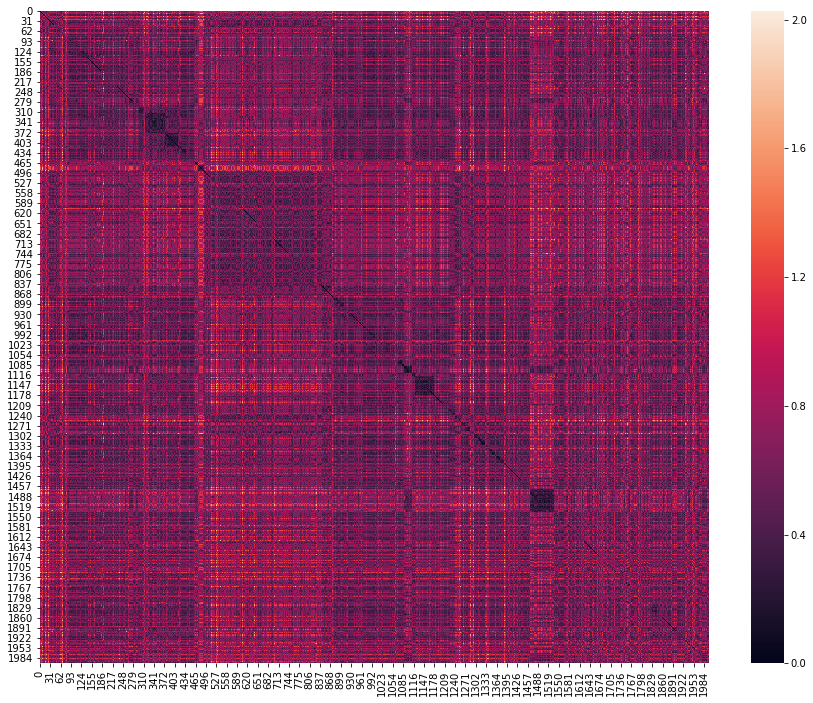

In [194]:
fig, ax = plt.subplots(figsize = (15,12))
heatmap(tracks_similarity, vmin = 0, vmax = tracks_similarity.max(), ax = ax)

plt.show()

## Clusterization Algorithms

In [195]:
model = AffinityPropagation(affinity = 'precomputed').fit(tracks_similarity)

Quantos labels foram feitos? 

In [199]:
len(np.unique(model.labels_))

13

Quantas playlists realmente existiam?

In [200]:
len(tracks.iloc[0:2000].playlist_id.unique())

27

In [214]:
model2 = DBSCAN(eps = 0.25, metric = 'precomputed').fit(tracks_similarity)

In [215]:
len(model2.labels_[model2.labels_ == -1])

114

In [217]:
len(np.unique(model2.labels_))

15

In [218]:
model3 = SpectralClustering(n_clusters=27, affinity='precomputed').fit(tracks_similarity)